# Initialization

In [1]:
import os
import sys
print(sys.executable)    # vérification
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable



/Users/gaelleba/anaconda3/envs/sparkEnv/bin/python


In [2]:

import pyspark
from pyspark.sql import SparkSession
import sparknlp
sparknlp.start()

#pip install --upgrade spark-nlp


25/01/02 16:45:06 WARN Utils: Your hostname, Gaelles-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.0.0.2 instead (on interface en0)
25/01/02 16:45:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/gaelleba/.ivy2/cache
The jars for the packages stored in: /Users/gaelleba/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-00181977-2304-4050-9040-cc761477f3a3;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.5.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in 

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52127)
Traceback (most recent call last):
  File "/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/site-packages/pyspark/a

In [3]:
print(pyspark.__version__)
print(sparknlp.version())

3.5.4
5.5.1


In [ ]:
!pwd

In [4]:
import pandas as pd
path='/Users/gaelleba/Library/CloudStorage/Dropbox/CNAM/RCP216/RCP216_PROJECT/'
source_file=f'{path}unique_abstracts_dates.csv'
df_abstracts=pd.read_csv(source_file, sep='\t', header=0)


In [5]:

def extract_year(pubdate):
    year = pubdate.strip("[]").split(',')[0]
    return int(year.strip("'"))

df_abstracts['Year'] = df_abstracts['Pubdate'].apply(extract_year)
#df_abstracts.info()
abstracts = df_abstracts["Abstract"].tolist()
years = df_abstracts["Year"].astype(int).tolist()

In [6]:
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import udf
spark = SparkSession.builder.getOrCreate()

# Define the schema
schema = StructType([
    StructField("abstract", StringType(), True),
    StructField("year", IntegerType(), True)
])

# Create DataFrame
data = [(abstracts[i], years[i]) for i in range(len(df_abstracts))]
Sptext = spark.createDataFrame(data, schema=schema)
Sptext.show(10)

## Create Full data frame
full = spark.read.format("csv").option("header", True) \
.option("sep", "\t") \
.load(source_file)

full = full.join(Sptext, on="abstract").drop("Pubdate")
full.show(10)

+--------------------+----+
|            abstract|year|
+--------------------+----+
|It has been firml...|2014|
|Although the asso...|2006|
|This study examin...|2014|
|The electrophysio...|2014|
|Time-of-day effec...|2000|
|Epidemiological a...|2017|
|TMS combined with...|2007|
|The aim of the pr...|2003|
|The authors studi...|2010|
|Despite the subje...|2018|
+--------------------+----+
only showing top 10 rows



Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=27438Kb max_used=27439Kb free=103633Kb
 bounds [0x00000001079e8000, 0x00000001094d8000, 0x000000010f9e8000]
 total_blobs=10198 nmethods=9241 adapters=867
 compilation: disabled (not enough contiguous free space left)
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+--------+----+
|            Abstract|               Title|                 DOI|          MeSH_Terms|         Pubmed link|drug_name_list|pubchem_id_list|    PMID|year|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+--------+----+
|It has been firml...|Oscillatory spati...|DOI: 10.1016/j.al...|['Adult', 'Alcoho...|https://pubmed.nc...|   ['Ethanol']|          [702]|24530007|2014|
|Although the asso...|Effects of alcoho...|DOI: 10.1111/j.15...|['Adult', 'Breath...|https://pubmed.nc...|   ['Ethanol']|          [702]|16737455

# Pre-traitement: embedding

In [12]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from sparknlp.pretrained import PretrainedPipeline

# Assemblage du document
documentAssembler = DocumentAssembler() \
                      .setCleanupMode("inplace") \
                      .setInputCol("Abstract") \
                      .setOutputCol("document")

embeddings = InstructorEmbeddings.pretrained() \
    .setInputCols(["document"]) \
    .setInstruction("Represent the biomedical abstracts for clustering: ") \
    .setOutputCol("instructor_embeddings")

finisher = EmbeddingsFinisher() \
                           .setInputCols("instructor_embeddings") \
                           .setOutputCols("output") \
                           .setOutputAsVector(True) \
                           .setCleanAnnotations(False)

# Pipeline
pipeline_embed = Pipeline(stages=[
    documentAssembler,
    embeddings,
    finisher
])
    
# Application du pipeline
model_embed = pipeline_embed.fit(full)
result_embed = model_embed.transform(full)
result_embed.printSchema()
result_embed.select("Title", "output").show(10, 300)

instructor_base download started this may take some time.


25/01/02 16:47:08 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 387.2 MB
[OK!]
root
 |-- Abstract: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- DOI: string (nullable = true)
 |-- MeSH_Terms: string (nullable = true)
 |-- Pubmed link: string (nullable = true)
 |-- drug_name_list: string (nullable = true)
 |-- pubchem_id_list: string (nullable = true)
 |-- PMID: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- instructor_embeddings: array (nullable = true)
 

+-----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                          Title|                                                                                                                                                                                                                                                                                                      output|
+---------------------------------------------------------------------------------------------------------

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.ml.functions import array_to_vector


# Define a UDF to average the vectors
def average_vectors(vectors):
    avg_vector = np.mean(vectors, axis=0).tolist()
    return avg_vector

average_vectors_udf = udf(average_vectors, ArrayType(FloatType()))
# Apply the UDF to create a new column with the averaged vectors
result_modif = result_embed.withColumn("mean_output", average_vectors_udf(result_embed["output"]))
result_modif.printSchema()

result_modif = result_modif.withColumn("features", array_to_vector("mean_output"))


result_modif.printSchema()
result_modif.select("Title", "features").show(10, 200)


root
 |-- Abstract: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- DOI: string (nullable = true)
 |-- MeSH_Terms: string (nullable = true)
 |-- Pubmed link: string (nullable = true)
 |-- drug_name_list: string (nullable = true)
 |-- pubchem_id_list: string (nullable = true)
 |-- PMID: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- instructor_embeddings: array (nullable = true)
 |    |-- element: struct (containsNull = tru

+-----------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                          Title|                                                                                                                                                                                                features|
+-----------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# PCA 

In [15]:
vector_size = result_modif.select("features").first()["features"].size
print(f"Size of the vectors in the features column: {vector_size}")

Size of the vectors in the features column: 768


In [16]:
from pyspark.ml.feature import PCA

# Décomposition en valeurs singulières (SVD), nombre k de composants retenus
MaxComp = 100
pca = PCA(k=MaxComp, inputCol="features", outputCol="PCA_Features")

# Application du pipeline avec SVD
model_pca = pca.fit(result_modif)
result_pca = model_pca.transform(result_modif)
result_pca.select("Title", "PCA_Features").show(10, 100)



25/01/02 16:52:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/02 16:53:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                               Title|                                                                                        PCA_Features|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Oscillatory spatial profile of alcohol's effects on the resting state: anatomically-constrained MEG.|[0.2901754624109584,0.14009488446999446,-0.06752208445079197,0.2394266809030489,0.055793175424193...|
|              Effects of alcohol on sleep and the sleep electroencephalogram in healthy young women.|[-0.2643007747252438,0.0025083751794219194,-0.04845484892253928,0.2412635040831739

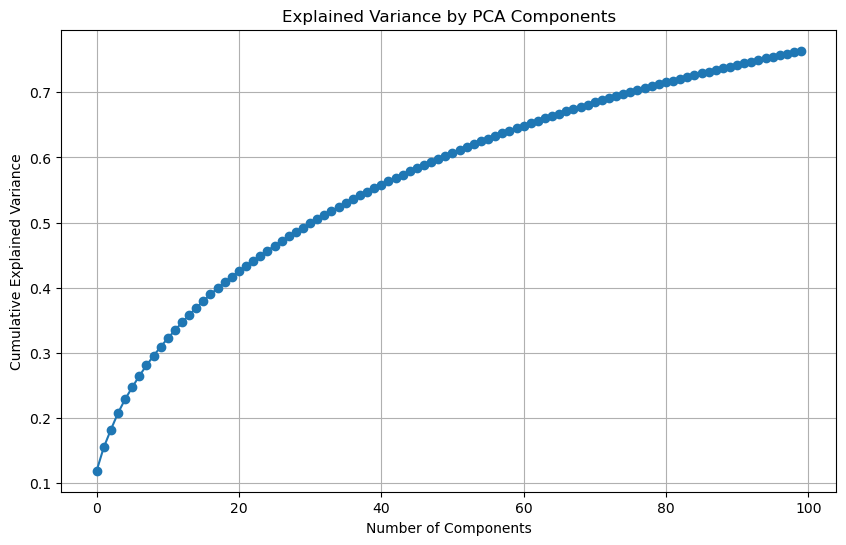

In [17]:
import numpy as np

import matplotlib.pyplot as plt

# Get the explained variance
explained_variance = model_pca.explainedVariance.toArray()

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

## Plotting 

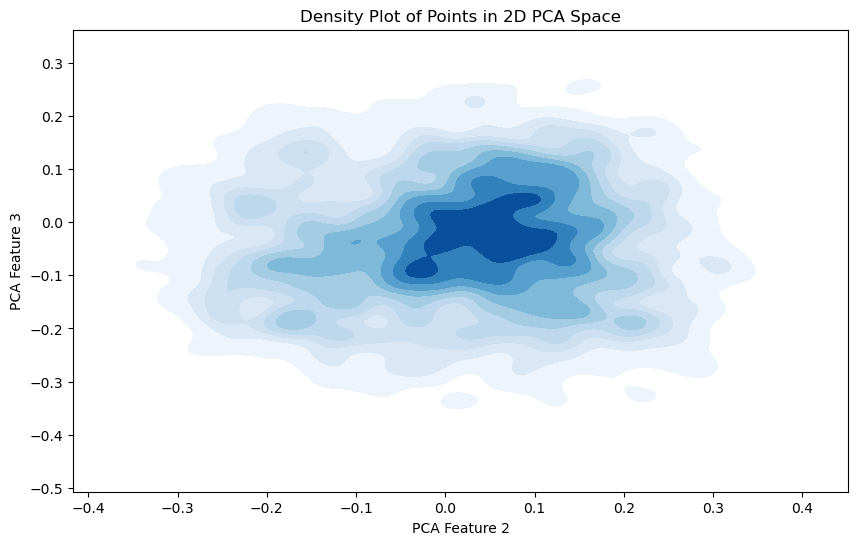

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extraction des caractéristiques PCA
pca_features = np.array(result_pca.select("PCA_Features").rdd.map(lambda row: row.PCA_Features).collect())

# Création du graphique de densité
plt.figure(figsize=(10, 6))
sns.kdeplot(x=pca_features[:, 1], y=pca_features[:, 2], cmap="Blues", fill=True, bw_adjust=0.5)
plt.title('Density Plot of Points in 2D PCA Space')
plt.xlabel('PCA Feature 2')
plt.ylabel('PCA Feature 3')
plt.show()


In [19]:
from pyspark.sql.functions import length

# Calculate the length of the abstract
result_pca = result_pca.withColumn("AbstractLength", length("Abstract"))
# Select necessary columns
data = result_pca.select("Title", "Year", "AbstractLength", "PCA_Features")
# Convert to Pandas DataFrame
pandas_df = data.toPandas()
# Extract PCA features into separate columns
pandas_df[['PCA1', 'PCA2', 'PCA3']] = pd.DataFrame(pandas_df['PCA_Features'].tolist(), index=pandas_df.index)[[0, 1, 2]]

25/01/02 17:00:08 ERROR RetryingBlockTransferor: Exception while beginning fetch of 1 outstanding blocks 
java.io.IOException: Connecting to /192.0.0.2:52122 failed in the last 4750 ms, fail this connection directly
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:210)
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:131)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:173)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.start(RetryingBlockTransferor.java:152)
	at org.apache.spark.network.netty.NettyBlockTransferService.fetchBlocks(NettyBlockTransferService.scala:151)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:102)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1172)
	at org.apache.spark.storage.BlockManage

KeyboardInterrupt: 

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


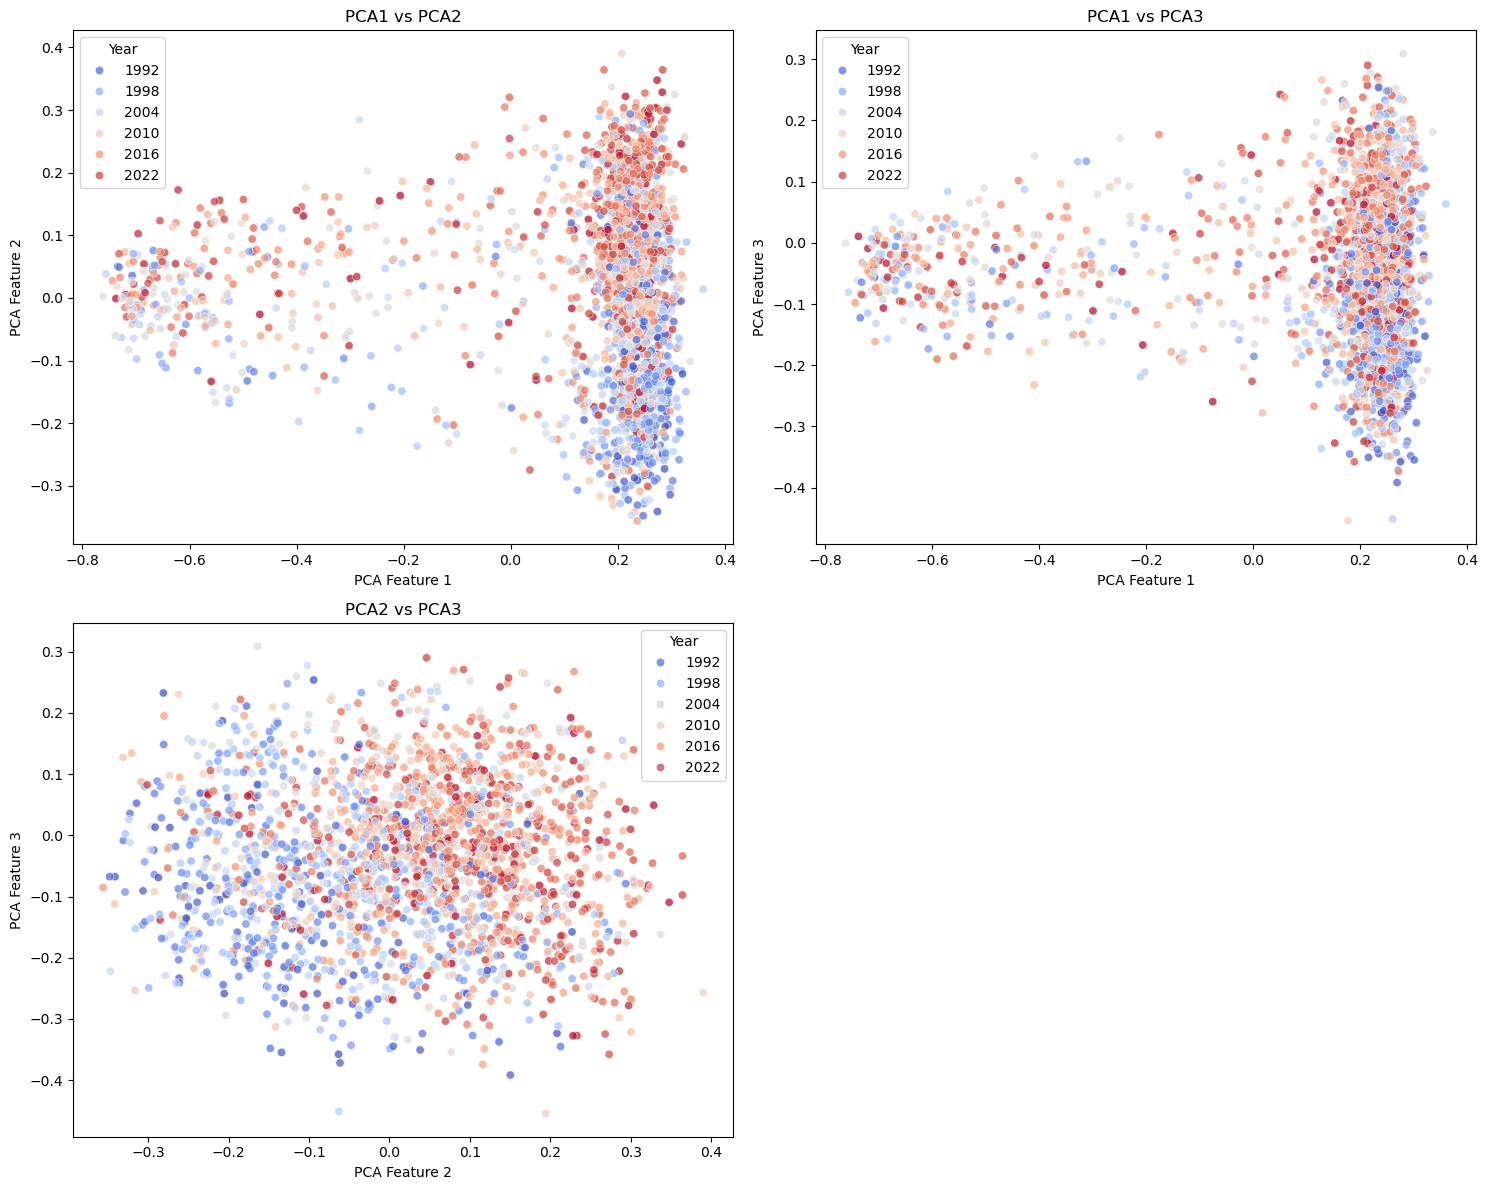

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def pca_plot(df, color_feature, palette):
    
    # Plot all PCA combinations in a single figure with small panels
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PCA Feature 1 vs PCA Feature 2
    sns.scatterplot(data=df, x='PCA1', y='PCA2', hue=color_feature, palette=palette, alpha=0.7, ax=axes[0, 0])
    axes[0, 0].set_title('PCA1 vs PCA2')
    axes[0, 0].set_xlabel('PCA Feature 1')
    axes[0, 0].set_ylabel('PCA Feature 2')

    # PCA Feature 1 vs PCA Feature 3
    sns.scatterplot(data=df, x='PCA1', y='PCA3', hue=color_feature, palette=palette, alpha=0.7, ax=axes[0, 1])
    axes[0, 1].set_title('PCA1 vs PCA3')
    axes[0, 1].set_xlabel('PCA Feature 1')
    axes[0, 1].set_ylabel('PCA Feature 3')

    # PCA Feature 2 vs PCA Feature 3
    sns.scatterplot(data=df, x='PCA2', y='PCA3', hue=color_feature, palette=palette, alpha=0.7, ax=axes[1, 0])
    axes[1, 0].set_title('PCA2 vs PCA3')
    axes[1, 0].set_xlabel('PCA Feature 2')
    axes[1, 0].set_ylabel('PCA Feature 3')

    # Hide the empty subplot
    axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    
pca_plot(pandas_df, 'Year', 'coolwarm')

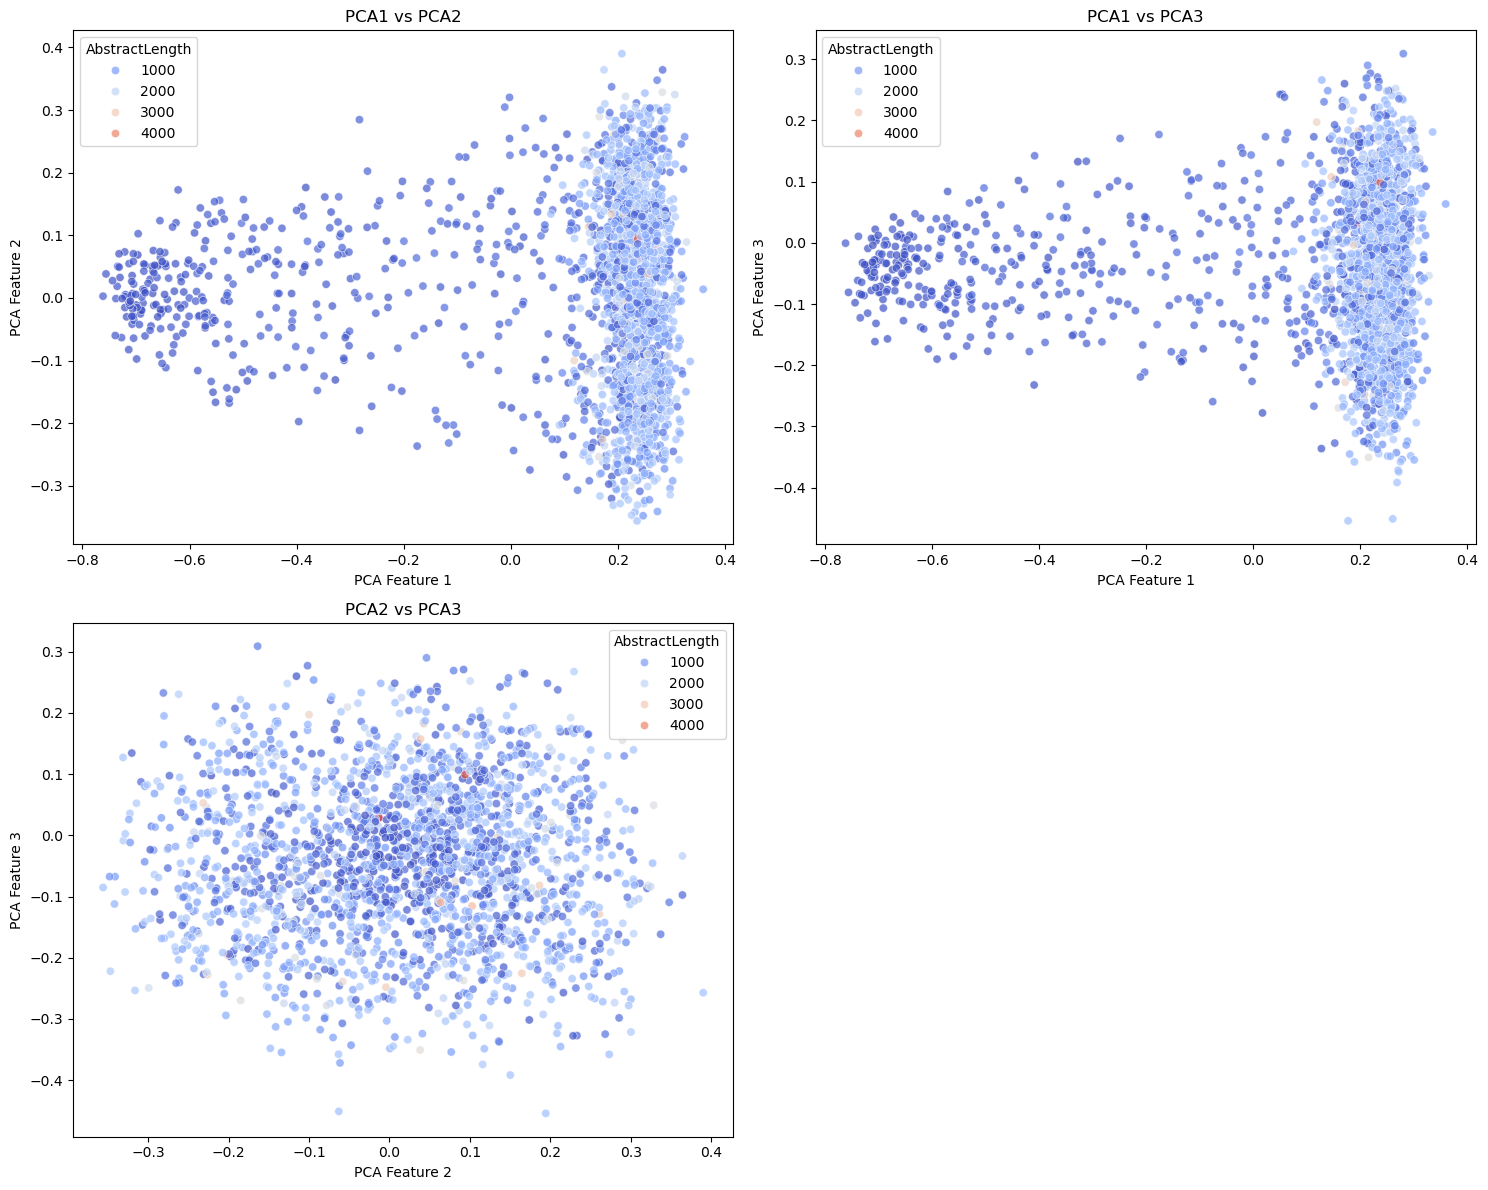

In [14]:
pca_plot(pandas_df, 'AbstractLength', 'coolwarm')

# K-means clustering

Silhouette :0.1379334671981294


Silhouette :0.1465517261934783


Silhouette :0.1103053698116858


Silhouette :0.14630077399623653


Silhouette :0.13499732180352758


Silhouette :0.14363824356735075


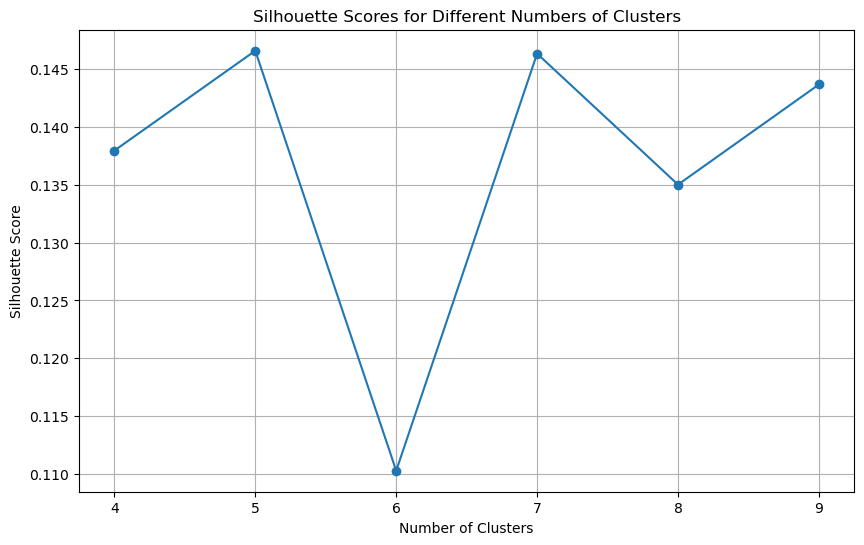

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt

# Initialize lists to store the number of clusters and corresponding silhouette scores
num_clusters = list(range(4, 10))
silhouette_scores = []

def test_kmeans(df, features):
    # Loop through the range of cluster numbers
    for k in num_clusters:
        # Apply k-means
        kmeans = KMeans().setK(k).setMaxIter(100).setSeed(100).setFeaturesCol(features).setPredictionCol("assigned_topic")
        model = kmeans.fit(df)
        
        # Transform the data
        kmeans_test = model.transform(df)
        
        # Evaluate the clustering by the silhouette score
        evaluator = ClusteringEvaluator().setFeaturesCol(features).setPredictionCol("assigned_topic")
        silhouette = evaluator.evaluate(kmeans_test)
        print('Silhouette :' + str(silhouette))
        
        # Append the silhouette score to the list
        silhouette_scores.append(silhouette)

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(num_clusters, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
test_kmeans(result_pca, "PCA_Features")

In [19]:
from pyspark.ml.clustering import KMeans


# Appliquer k-means
kmeans = KMeans()\
    .setK(10)\
    .setMaxIter(200)\
    .setSeed(100)\
    .setFeaturesCol("PCA_Features").setPredictionCol("assigned_topic")
    
modele = kmeans.fit(result_pca)

# Trouver l'indice de groupe pour chaque donnée
kmeans_res = modele.transform(result_pca)
kmeans_res.select('Title', 'assigned_topic').show(10)

+--------------------+--------------+
|               Title|assigned_topic|
+--------------------+--------------+
|Oscillatory spati...|             0|
|Effects of alcoho...|             1|
|Spatio-temporal p...|             4|
|Alcohol reduces c...|             0|
|Time-of-day effec...|             0|
|Impairment due to...|             1|
|Effects of alcoho...|             0|
|Convergent and di...|             9|
|When the brain ch...|             9|
|Effects of alcoho...|             0|
+--------------------+--------------+
only showing top 10 rows



In [20]:
# Évaluer la classification par le coefficient de silhouette
from pyspark.ml.evaluation import ClusteringEvaluator
evaluateur = ClusteringEvaluator() \
    .setFeaturesCol("features") \
    .setPredictionCol("assigned_topic")
silhouette = evaluateur.evaluate(kmeans_res)
print("Silhouette : " + str(silhouette))


Silhouette : 0.08946644621685534


## Plot in PCA plans

In [21]:
# Convert to Pandas DataFrame
kmeans_df = kmeans_res.toPandas()

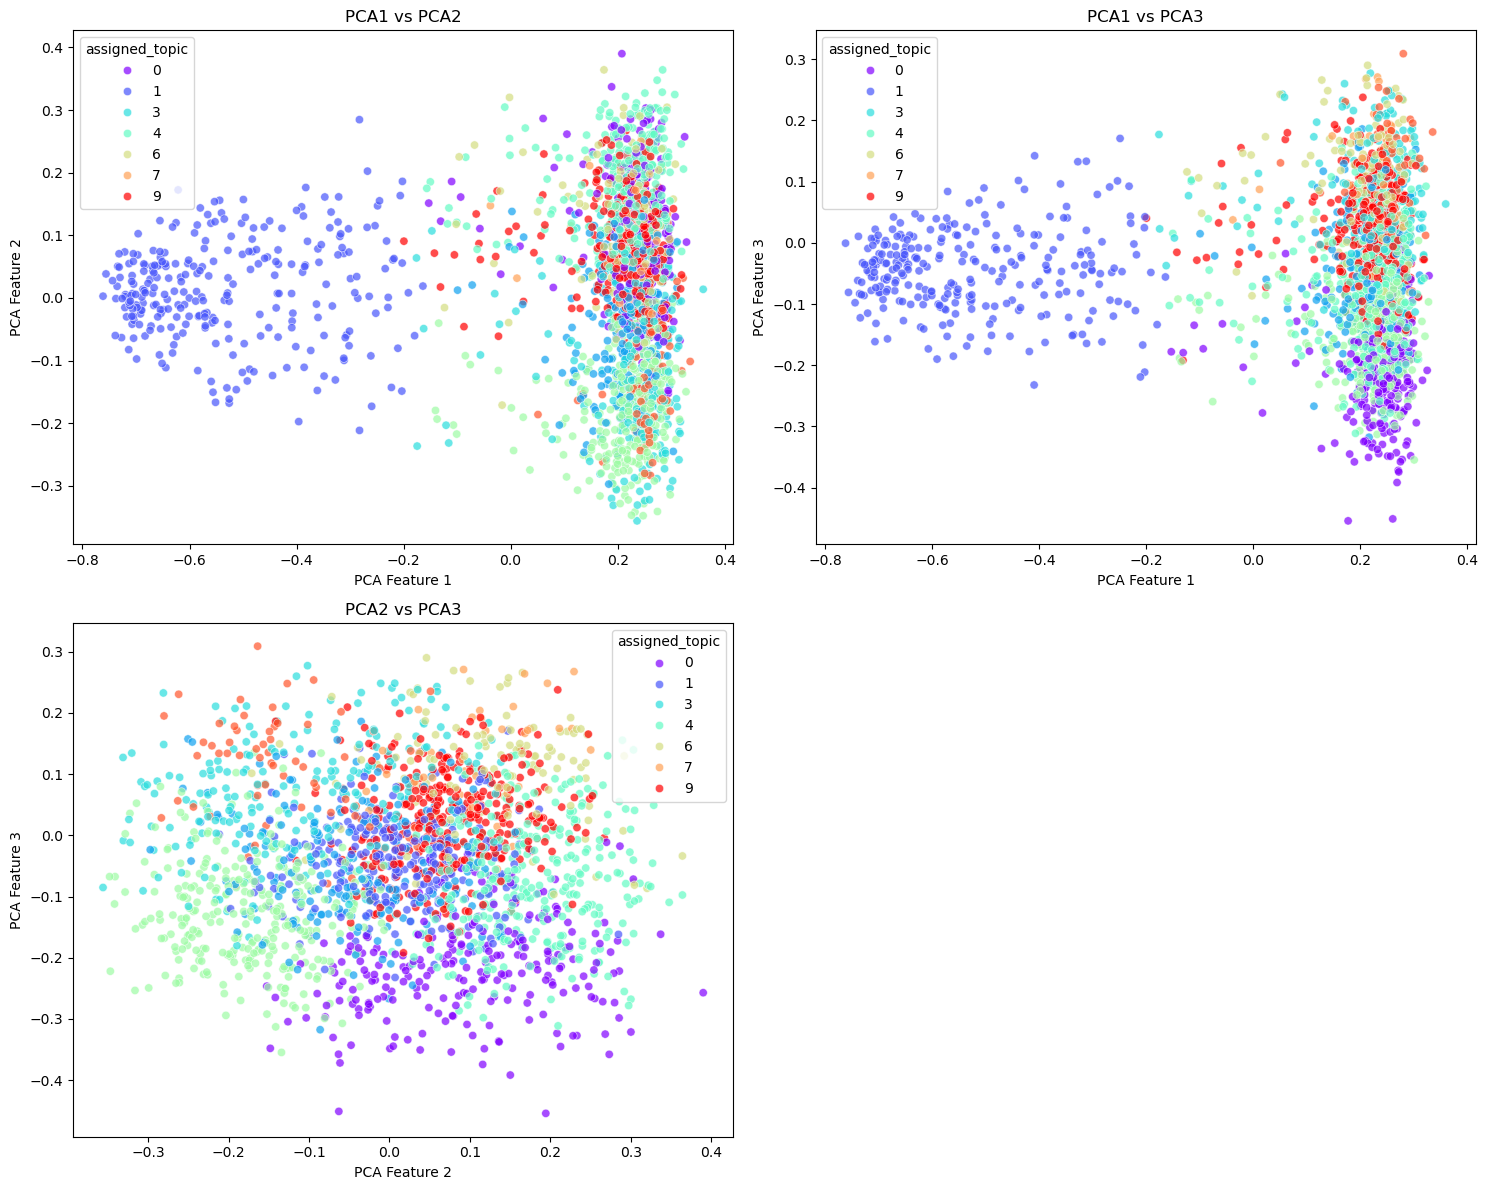

In [22]:
# Extract PCA features into separate columns
kmeans_df[['PCA1', 'PCA2', 'PCA3']] = pandas_df[['PCA1', 'PCA2', 'PCA3']]


pca_plot(kmeans_df, 'assigned_topic', 'rainbow')

# Clusters description

In [ ]:
# Afficher les centres des groupes
centres = modele.clusterCenters()
print("Centres : ")
for centre in modele.clusterCenters():
    print(centre)

# Save results classification

In [23]:
import os
from pyspark.sql.functions import expr, col, array_max
import datetime

# Create the folder if it doesn't exist
output_folder = os.path.join(path, '2-AbstractsCollection/Classification_results')
os.makedirs(output_folder, exist_ok=True)

# Save the list of articles (pmid + topic assigned)
date = datetime.datetime.now().strftime("%Y-%m-%d")
articles_output_path = os.path.join(output_folder, f'articles_InstructorEmbeddings_PCA100_kmeans10_{date}.csv')
kmeans_df.to_csv(articles_output_path, index=False)
